In [68]:
import numpy as np
from matplotlib import pyplot as plt
import emcee
import corner
import os 
import pandas as pd


# Define some functions
def d2r(x): return np.deg2rad(x)
def sin(x): return np.sin(x)
def cos(x): return np.cos(x)
def log(x): return np.log(x)
def log10(x): return np.log10(x)

def model(x,param):
    '''
    The empirical function; Lumme–Muinonen function
    (Lumme & Muinonen 1993; Penttilä et al. 2005).
    We  modify  the  original  Lumme–Muinonenfunction.
    More detail in Geem et al. 2021
    '''
    h,a0,c1,c2 = param
    x = np.array(x)
    x,a0  = d2r(x), d2r(a0)
    y = h / (np.pi/180) * (sin(x)/sin(a0))**c1 * (cos(x/2.)/cos(a0/2.))**c2 * sin(x - a0)
    return y 

def lnlike(param,alpha,Pr,err):
    '''
    Likelyhood is -infinite ~ 0
    '''
    h,a0,c1,c2 = param
    alpha = np.array(alpha)
    Pr = np.array(Pr)
    err = np.array(err)
    m = model(alpha,param)
    
    return -0.5*np.sum(((Pr - m)/err)**2 )


def lnprior(param):
    '''
    Set the boundary of parameters
    slope h = [0,1]
    inversion angle (a0) = [10,40]
    c1 = [0,10]
    c2 = [0,10]
    '''
    h,a0,c1,c2 = param[0],param[1],param[2], param[3]
    if 1 > h > 0 and 40 > a0 > 10 and 10 > c1 > 0 and 10 > c2 > 0:
        return 0.0
    else:
        return -np.inf
    
def lnprob(param,alpha,Pr,err):
    alpha = np.array(alpha)
    Pr = np.array(Pr)
    err = np.array(err)
    
    lp = lnprior(param)
    if not np.isfinite(lp):
        return -np.inf
    elif lp == 0.0:
        return lp + lnlike(param,alpha,Pr,err)      
    
    
path = os.path.join('/home/judy/Dropbox/Research','Pirka_MSI','ACOs')
QY1 = pd.read_csv(os.path.join(path,'QY1_result.csv'))
DonQui = pd.read_csv(os.path.join(path,'DonQuixote_result.csv'))
Hidalgo = pd.read_csv(os.path.join(path,'Hidalgo_result.csv'))    

QY1_R = QY1[QY1['Filter']=='Rc']
QY1_V = QY1[QY1['Filter']=='V']
DonQui_R = DonQui[DonQui['Filter']=='Rc']
DonQui_I = DonQui[DonQui['Filter']=='Ic']
Hidalgo = Hidalgo
Hidalgo_R = Hidalgo.append({'alpha':26.8,
                             'Pr':2.49,
                             'ePr':0.04},
                            ignore_index=True) #Add data point from Fornasier 2014

## MCMC fitting

  0%|          | 9/5000 [00:00<00:58, 86.03it/s]

(331471) 1984 QY1


100%|██████████| 5000/5000 [00:38<00:00, 130.68it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

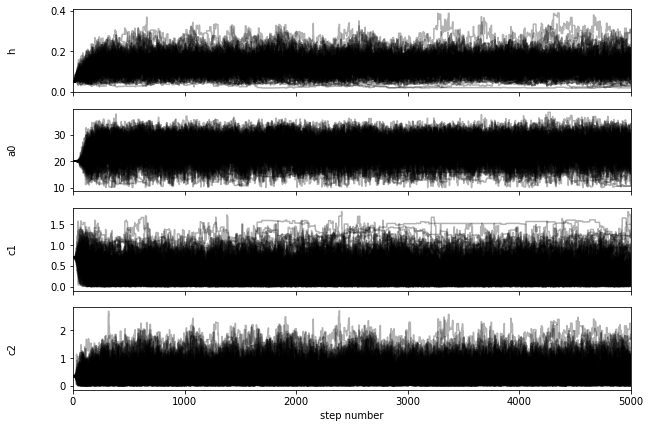

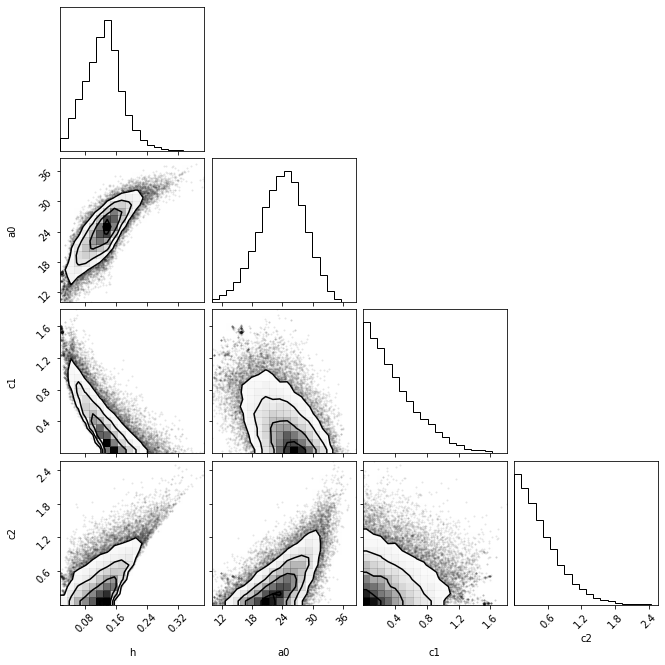

In [73]:
print('(331471) 1984 QY1')
nwalkers = 100
niter = 10
initial = np.array([0.05,20,0.7,0.35])   #Don Quixote, Hidalgo = [0.9,20,0.7,0.35], 1984 QY1 (both V and Rc) = [0.05,20,0.7,0.35]
ndim = len(initial)
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,
                               args = (QY1_V['alpha'],
                                       QY1_V['Pr'],
                                       QY1_V['ePr']) )
sampler.run_mcmc(p0, 5000, progress = True)

fig,axes = plt.subplots(4,figsize=(10,7), sharex = True)
samples = sampler.get_chain()
labels = ['h','a0','c1','c2']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
 
axes[-1].set_xlabel("step number");    

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(
    flat_samples, labels=labels
);
inds = np.random.randint(len(flat_samples), size=100)

#Parameter 
from IPython.display import display, Math
result = []
up_lim = []
low_lim = []
for i in range(ndim):
    
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84]) #-1sigma, 0sigma, 1sigma #Get 1-sigma uncertainty
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    result.append(mcmc[1])
    up_lim.append(q[1])
    low_lim.append(q[0])

## Derive geometric albedo

In [84]:
def h2albedo(h,err_h):
    '''
    Using log(p_V) = C1 * log(h) + C2, determine the geometric albedo.
    we use C_1 = -1.016 \pm 0.010 and C_2= -1.719 \pm 0.012 from Lupishko+2018
    '''
    
    slope = h
    dh = err_h
    
    C1 = -1.016
    C2 = -1.719
    err_C1 = 0.010
    err_C2 = 0.012
        
    albedo = 10 ** (C1 * log10(slope) + C2)
    d_albedo = np.abs(albedo)* np.log(10)*((C1*log10(slope)*np.sqrt((err_C1/C1)**2
                                             + (dh/(log10(h)*log(10)*h))**2))**2 + err_C2**2)**(1/2)#Based on the error propagation
    
    return albedo, d_albedo


pv0,err_pv0 = h2albedo(result[0],0)   
pv_up,err_pv_up = h2albedo(result[0]-low_lim[0], 0)   
pv_low,err_pv_low = h2albedo(result[0]+up_lim[0], 0)

print('''
The derived slope h is {0:.4f} (+{1:.4f}) (-{2:.4f}) %/deg
and the corresponding geomgeric albedo is pV = {3:.4f} (+{4:.4f}) (-{5:.4f}).
If we consider the uncertainty from the the equation of log(p_V) = C1 * log(h) + C2, then
pV = {6:.4f} (+{7:.4f}) (-{8:.4f})



Thus, the derived geometric albedo value is

'''.format(result[0],up_lim[0],low_lim[0],
           pv0, pv_up-pv0,               pv0-pv_low,
           pv0, (pv_up+err_pv_up)-pv0,  pv0-(pv_low-err_pv_low)))

txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
txt = txt.format(pv0, pv0-(pv_low-err_pv_low),(pv_up+err_pv_up)-pv0,'p_{V}')  
display(Math(txt))    


The derived slope h is 0.1290 (+0.0436) (-0.0499) %/deg
and the corresponding geomgeric albedo is pV = 0.1529 (+0.0985) (-0.0391).
If we consider the uncertainty from the the equation of log(p_V) = C1 * log(h) + C2, then
pV = 0.1529 (+0.1079) (-0.0429)



Thus, the derived geometric albedo value is




<IPython.core.display.Math object>

test